In [1]:
import time 
from SimpleFSM import FSM, State, state_action, state_transition

# Toy Example Notebook 
This notebook is to make demonstrating and live testing the SimpleFSM package easier. Below is the class to demonstrate how the specified toy example can be solved with this frame work

*Jonathan Thompson*

In [2]:
# Helper methods to make a generator for testing
def list_token_generator(data_list):
    for item in data_list:
        time.sleep(3)
        yield item

data_list_alternates = ['strawberry', 'lemon', 'strawberry', 'lemon', 'strawberry', 'lemon', 'strawberry', 'lemon', 'strawberry']
data_list_strawberry_repeats = ['strawberry', 'lemon', 'strawberry', 'strawberry', 'lemon', 'strawberry', 'lemon', 'strawberry']
data_list_3_strawberry = ['strawberry', 'lemon', 'strawberry', 'strawberry','strawberry']
data_list_both_repeats = ['strawberry', 'lemon', 'strawberry', 'strawberry','strawberry', 'strawberry', 'strawberry', 'lemon', 'lemon', 'lemon', 'lemon']

## Toy Problem 

In [3]:
class LollipopFSM(FSM):
  normal_state = State("normal_state", is_start=True)
  alert_state = State("alert_state")
  non_normal_state = State("non_normal_state")

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  @staticmethod
  @state_action("normal_state")
  def process_normal(event_item, context_data)->None:
    print("processing normally")

  @staticmethod
  @state_transition("normal_state", ["normal_state", "alert_state"])
  def normal_transition(event_item, context_data)->str:
    if event_item == context_data['last_flavor']:
      if context_data['streak'] == 2:
        return "alert_state"
      else:
        context_data["streak"] += 1
    else: 
      context_data['last_flavor'] = event_item
      context_data["streak"] = 1
    
    return "normal_state"

  @staticmethod
  @state_action("alert_state")
  def process_alert(event_item, context_data)->None:
     print(f"Alert: More than 2 {context_data['last_flavor']} encountered")


  @staticmethod
  @state_transition("alert_state", ["normal_state", "non_normal_state"])
  def alert_transition(event_item, context_data)->str:
    if event_item == context_data['last_flavor']:
      context_data["streak"] += 1
      return 'non_normal_state'
    else:
      context_data['last_flavor'] = event_item
      context_data["streak"] = 1
      return 'normal_state'
    
  @staticmethod
  @state_action("non_normal_state")
  def process_non_normal(event_item, context_data)->None:
    print("processing in non-normal state")

  @staticmethod
  @state_transition("non_normal_state", ["normal_state", "non_normal_state"])
  def non_normal_transition(event_item, context_data)->str:
    if event_item != context_data['last_flavor']:
      context_data['last_flavor'] = event_item
      context_data["streak"] = 1
      return 'normal_state'
    else:
      context_data["streak"] += 1
      return 'non_normal_state'


In [4]:
list_gen = list_token_generator(data_list_alternates)
lollie = LollipopFSM(replace_checkpoint=True, checkpoint_every=2, user_context_data={'streak': 0, 'last_flavor': None})

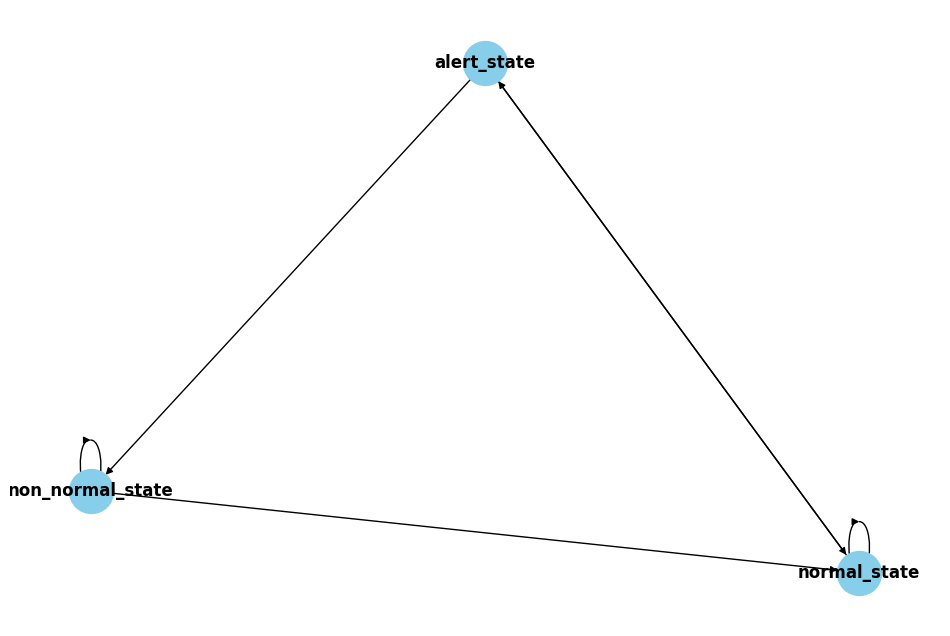

In [5]:
lollie.plot_graph(fig_size=(12, 8))

In [6]:
lollie.start(list_gen)

processing normally
processing normally
processing normally
processing normally
processing normally
processing normally
processing normally
processing normally
processing normally
save and exit


In [5]:
# With strawberry repeat
list_gen = list_token_generator(data_list_strawberry_repeats)
lollie = LollipopFSM(replace_checkpoint=False, checkpoint_every=2, user_context_data={'streak': 0, 'last_flavor': None})
lollie.start(list_gen)

processing normally
processing normally
processing normally
processing normally
processing normally
processing normally
processing normally
processing normally
save and exit


In [8]:
# With > 3 strawberries
list_gen = list_token_generator(data_list_3_strawberry)
lollie = LollipopFSM(replace_checkpoint=True, checkpoint_every=2, user_context_data={'streak': 0, 'last_flavor': None})
lollie.start(list_gen)


processing normally
processing normally
processing normally
processing normally
Alert: More than 2 strawberry encountered
save and exit


In [9]:
# Multiple repeats for both strawberry and lemon
list_gen = list_token_generator(data_list_both_repeats)
lollie = LollipopFSM(replace_checkpoint=True, checkpoint_every=2, user_context_data={'streak': 0, 'last_flavor': None})
lollie.start(list_gen)

processing normally
processing normally
processing normally
processing normally
Alert: More than 2 strawberry encountered
processing in non-normal state
processing in non-normal state
processing normally
processing normally
Alert: More than 2 lemon encountered
processing in non-normal state
save and exit


## Restoring from Checkpoint

In [4]:
data_list_1st_half = ['strawberry', 'lemon', 'strawberry', 'strawberry']
data_list_2nd_half = ['strawberry', 'strawberry', 'strawberry', 'lemon', 'lemon', 'lemon', 'lemon']

In [5]:
# Delete all pkl files in data dir for test
from pathlib import Path

data_dir = Path("./data")
for file_path in data_dir.glob("*.pkl"):
    file_path.unlink()

def print_fsm_state(fsm_obj):
    print(f'num events processed: {fsm_obj._events_processed}')
    print(f'num events processed: {fsm_obj.current_state.name}')
    print(f'user context: {fsm_obj.user_context_data}')

In [6]:
list_gen = list_token_generator(data_list_1st_half)
lollie_v1 = LollipopFSM(replace_checkpoint=True, checkpoint_every=2, user_context_data={'streak': 0, 'last_flavor': None})
lollie_v1.start(list_gen)

processing normally
processing normally
processing normally
processing normally
save and exit


In [7]:
print_fsm_state(lollie_v1)

num events processed: 4
num events processed: normal_state
user context: {'streak': 2, 'last_flavor': 'strawberry'}


In [8]:
list_gen = list_token_generator(data_list_2nd_half)
lollie_v2 = LollipopFSM(start_from_checkpoint_file="./data/LollipopFSM_checkpoint.pkl")

In [9]:
print_fsm_state(lollie_v2)

num events processed: 4
num events processed: normal_state
user context: {'streak': 2, 'last_flavor': 'strawberry'}


In [10]:
list_gen = list_token_generator(data_list_1st_half)
lollie_v2.start(list_gen)

Alert: More than 2 strawberry encountered
processing in non-normal state
processing in non-normal state
processing normally
processing normally
Alert: More than 2 lemon encountered
processing in non-normal state
save and exit
